# Test MH harmonic

In [1]:
import os, sys, time
import argparse
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.random as random
import toml
import numpyro
from functools import partial
import micmac
from micmac import *
from fgbuster.observation_helpers import *

In [2]:
from jax import config
current_path = os.path.abspath('')
sys.path.append(current_path)

config.update("jax_enable_x64", True)

In [3]:
path_toml_file = current_path+'/Harm_fullsky_v1a.toml'
path_home_test_playground = os.path.dirname(current_path) + '/'

In [4]:
MICMAC_obj = create_Harmonic_MICMAC_sampler_from_toml_file(path_toml_file)


In [5]:
seed_realization_input = MICMAC_obj.seed

In [6]:
fgs_model_ = 'd7s0'
instr_name = MICMAC_obj.instrument_name #'SO_SAT'

path_Fisher = path_home_test_playground + f'Fisher_matrix_{MICMAC_obj.instrument_name}_EB_model_{fgs_model_}_noise_True_seed_42_lmin2_lmax128.txt'
try :
    Fisher_matrix = np.loadtxt(path_Fisher)
except:
    print("Fisher matrix not found !", flush=True)
    Fisher_matrix = np.loadtxt(path_home_test_playground + f'Fisher_matrix_{MICMAC_obj.instrument_name}_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt')


In [7]:
instrument = get_instrument(instr_name)


In [8]:
np.random.seed(seed_realization_input)
freq_maps_fgs_noised = get_observation(instrument, fgs_model_, nside=MICMAC_obj.nside, noise=True)[:, 1:, :]   # keep only Q and U
np.random.seed(seed_realization_input)
freq_maps_fgs_denoised = get_observation(instrument, fgs_model_, nside=MICMAC_obj.nside, noise=False)[:, 1:, :]   # keep only Q and U

noise_map = freq_maps_fgs_noised - freq_maps_fgs_denoised
 

freq_maps_fgs = freq_maps_fgs_denoised + noise_map


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


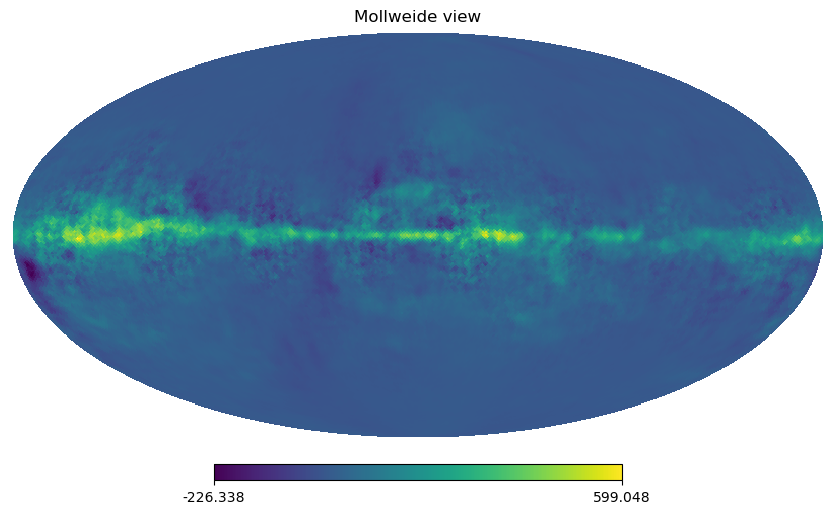

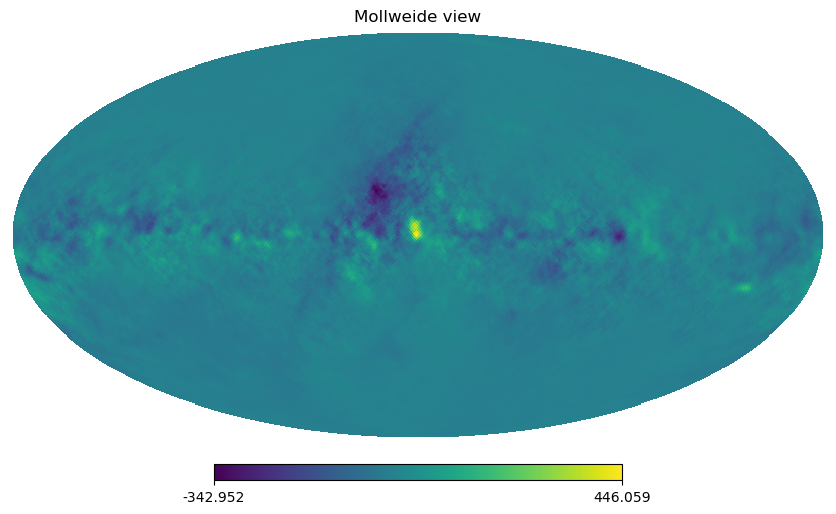

In [26]:
hp.mollview(freq_maps_fgs[-1,0])
hp.mollview(freq_maps_fgs[-1,1])

In [9]:
# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_obj.n_components, pos_special_freqs=[0,-1])

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_obj.n_components, init_params, pos_special_freqs=[0,-1])
mixing_matrix_sampled = mixing_matrix_obj.get_B()



In [10]:
# frequency_inv_noise_cell = get_true_Cl_noise(instrument['depth_p'], MICMAC_obj.lmax)

# MICMAC_obj.freq_noise_c_ell = frequency_inv_noise_cell

In [11]:
covariance_matrix = np.linalg.inv(Fisher_matrix)

MICMAC_obj.covariance_step_size_B_f = covariance_matrix[:-1, :-1]
MICMAC_obj.step_size_r = np.sqrt(covariance_matrix[-1, -1])

In [12]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)


Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [13]:
theoretical_r0_total = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)
theoretical_r1_tensor = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)

c_ell_approx = np.zeros((3,MICMAC_obj.lmax+1))
c_ell_approx[0,MICMAC_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_obj.lmin:] = theoretical_r0_total[1,:]

red_cov_approx_matrix = get_reduced_matrix_from_c_ell_jax(c_ell_approx)[MICMAC_obj.lmin:]

In [14]:
len_pos_special_freqs = len(MICMAC_obj.pos_special_freqs)

## Starting MH

In [15]:
minimum_std_Fisher_diag = jnp.diag(scipy.linalg.sqrtm(jnp.linalg.inv(Fisher_matrix)))
sigma_gap = 20

dimension_free_param_B_f = 2*(MICMAC_obj.n_frequencies-len_pos_special_freqs)

In [16]:
np.random.seed(MICMAC_obj.seed)
first_guess = jnp.zeros(dimension_free_param_B_f)
first_guess = first_guess.at[MICMAC_obj.indexes_free_Bf].set(
    init_params.ravel(order='F')[MICMAC_obj.indexes_free_Bf] + minimum_std_Fisher_diag[:-1]*np.random.uniform(low=-sigma_gap,high=sigma_gap, size=(dimension_free_param_B_f)))
init_params_mixing_matrix = first_guess.reshape((MICMAC_obj.n_frequencies-len_pos_special_freqs),2,order='F')

first_guess_r = 1e-5

In [17]:
MICMAC_obj.number_iterations_sampling = 10000

In [18]:
jnp.diag(sp.linalg.sqrtm(covariance_matrix))

Array([1.21757644e-04, 4.70550551e-05, 4.41665409e-05, 5.19700161e-05,
       3.87544198e-05, 1.49239634e-05, 1.40337135e-05, 1.65568746e-05,
       5.55036342e-04], dtype=float64)

In [19]:
# perform_harmonic_MH(MICMAC_obj, input_freq_maps, c_ell_approx, init_params_mixing_matrix, initial_guess_r=first_guess_r,
#                                     covariance_B_f_r=covariance_matrix, theoretical_r0_total=theoretical_r0_total, theoretical_r1_tensor=theoretical_r1_tensor)

MICMAC_obj.perform_harmonic_MH(input_freq_maps, c_ell_approx, init_params_mixing_matrix, initial_guess_r=first_guess_r,
                                    covariance_B_f_r=covariance_matrix, theoretical_r0_total=theoretical_r0_total, theoretical_r1_tensor=theoretical_r1_tensor)

Covariance B_f, r [[ 1.53880528e-08  2.68059803e-09  2.34244858e-09  1.50290854e-09
  -2.37978234e-09 -1.37233311e-10 -9.99848056e-11 -6.29078811e-11
   0.00000000e+00]
 [ 2.68059803e-09  3.56982142e-09  3.20325775e-09  2.17655293e-09
  -1.37246147e-10 -1.57972740e-10 -1.24107536e-10 -9.84123630e-11
  -0.00000000e+00]
 [ 2.34244858e-09  3.20325775e-09  3.31882911e-09  2.25192620e-09
  -9.99966002e-11 -1.24107209e-10 -1.70056760e-10 -1.28210812e-10
  -0.00000000e+00]
 [ 1.50290854e-09  2.17655293e-09  2.25192620e-09  3.33395124e-09
  -6.29122555e-11 -9.84075797e-11 -1.28206528e-10 -4.00899589e-10
   0.00000000e+00]
 [-2.37978234e-09 -1.37246147e-10 -9.99966002e-11 -6.29122555e-11
   1.76030702e-09  2.75697212e-10  2.38694573e-10  1.53007097e-10
  -0.00000000e+00]
 [-1.37233311e-10 -1.57972740e-10 -1.24107209e-10 -9.84075797e-11
   2.75697212e-10  3.64415309e-10  3.25028779e-10  2.22421683e-10
   0.00000000e+00]
 [-9.99848056e-11 -1.24107536e-10 -1.70056760e-10 -1.28206528e-10
   2.38694

sample: 100%|██████████| 10000/10000 [06:48<00:00, 24.45it/s]


End of MH iterations for harmonic run in 6.819807720184326 minutes, now saving results !
Test [[3.37977118e-01 3.04790163e-02 1.03919821e-02 ... 1.28891044e-01
  4.41010123e-01 1.00000000e-05]
 [3.37946960e-01 3.04361189e-02 1.03063240e-02 ... 1.28916359e-01
  4.41021139e-01 1.16562979e-03]
 [3.37946960e-01 3.04361189e-02 1.03063240e-02 ... 1.28916359e-01
  4.41021139e-01 1.16562979e-03]
 ...
 [3.38770685e-01 2.74554994e-02 5.23325679e-03 ... 1.47183289e-01
  4.64960239e-01 1.22868917e-01]
 [3.38770685e-01 2.74554994e-02 5.23325679e-03 ... 1.47183289e-01
  4.64960239e-01 1.22868917e-01]
 [3.38770685e-01 2.74554994e-02 5.23325679e-03 ... 1.47183289e-01
  4.64960239e-01 1.22868917e-01]]
Test size (10000, 9)

                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.34      0.00      0.34      0.34      0.34      4.00      1.78
Param:0[1]      0.03      0.00      0.03      0.03      0.03      2.93      3.46
Param:0[2]      0.01      0.00      0.01 

In [20]:
MICMAC_obj.all_samples_r.shape

(10000,)

In [21]:
MICMAC_obj.all_params_mixing_matrix_samples.shape

(10000, 4, 2)

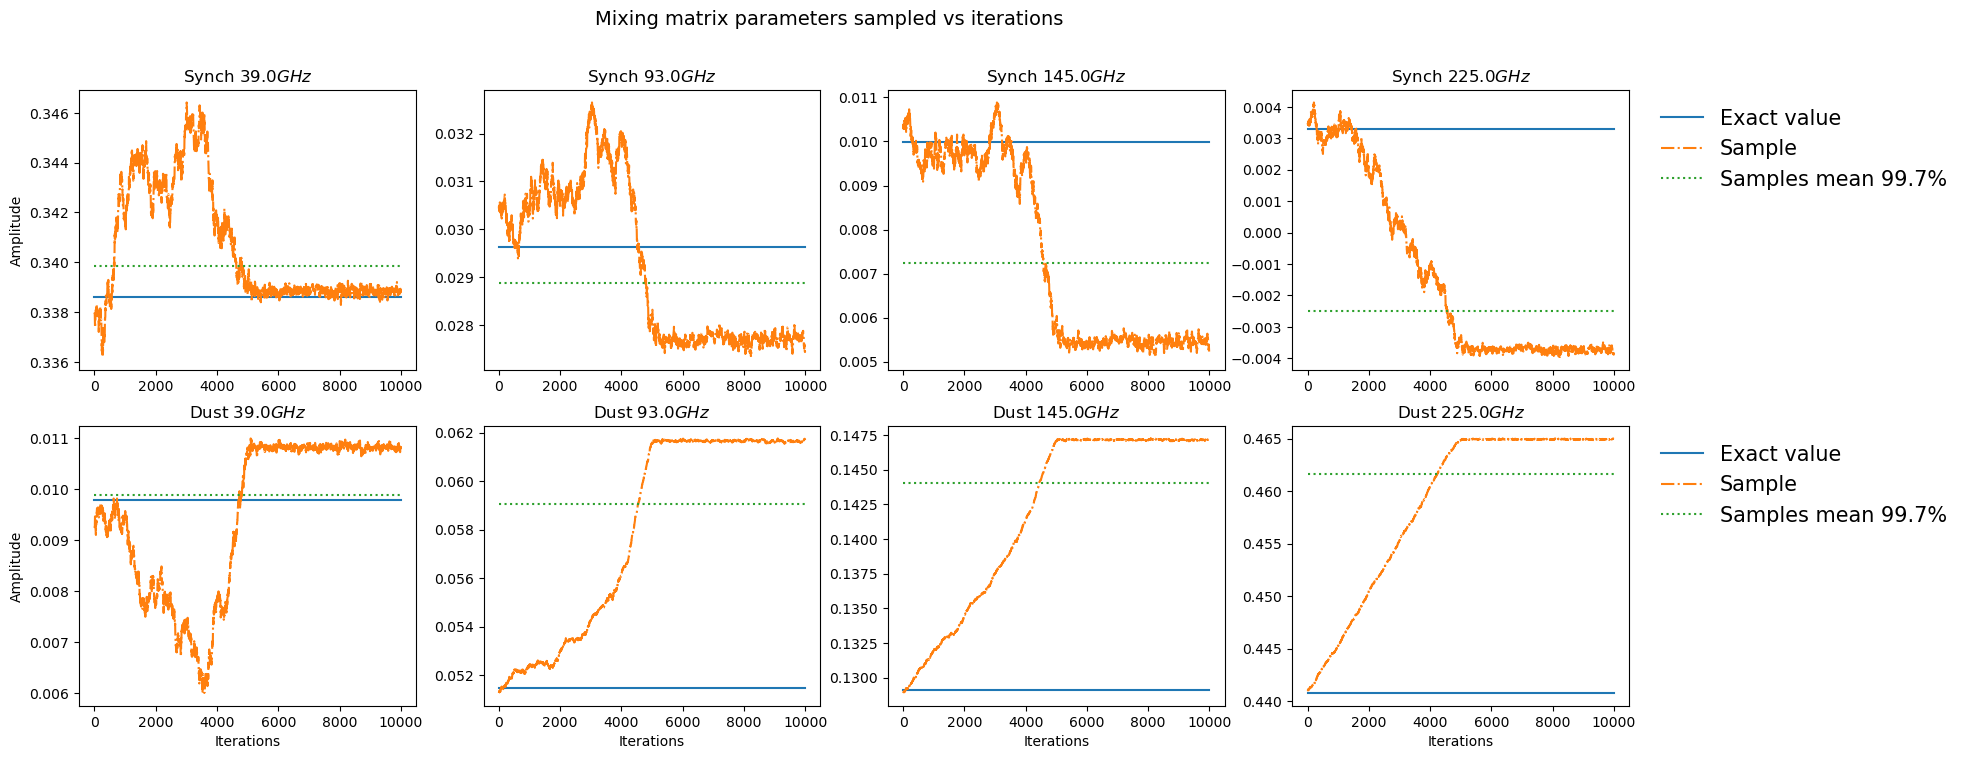

In [22]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_obj.lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])

all_B_f_sample_synch = MICMAC_obj.all_params_mixing_matrix_samples[:,:,0]
all_B_f_sample_dust = MICMAC_obj.all_params_mixing_matrix_samples[:,:,1]

frequency_array = np.array(instrument['frequency'])


if MICMAC_obj.n_frequencies-len_pos_special_freqs < 10:
    plt.figure(figsize=(20,8))
    plt.suptitle('Mixing matrix parameters sampled vs iterations', fontsize=14)
    # plt.subplot(121)

    for i in range(MICMAC_obj.n_frequencies-len_pos_special_freqs):
        plt.subplot(201+len(frequency_Bf)*10+i)
        plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
        plt.plot([0,MICMAC_obj.number_iterations_sampling], [init_params[i,0],init_params[i,0]], label='Exact value')
        plt.plot(np.arange(MICMAC_obj.number_iterations_sampling), all_B_f_sample_synch[:,i], '-.', label='Sample')
        
        n_sigma = 3
        transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
        cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
        mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
        std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

        mean_value = all_B_f_sample_synch[:,i].mean()
        plt.plot([0,MICMAC_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

        # plt.yscale('log')
        # plt.xlabel('Iterations')
        if i == 0:
            plt.ylabel('Amplitude')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

    # plt.figure(figsize=(20,8))
    # plt.subplot(122)
    for i in range(MICMAC_obj.n_frequencies-len_pos_special_freqs):
        plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
        # plt.subplot(201+len(frequency_Bf)*10+i)
        plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
        plt.plot([0,MICMAC_obj.number_iterations_sampling], [init_params[i,1],init_params[i,1]], label='Exact value')
        plt.plot(np.arange(MICMAC_obj.number_iterations_sampling), all_B_f_sample_dust[:,i], '-.', label='Sample')

        n_sigma = 3
        transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
        cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
        mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
        std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

        mean_value = all_B_f_sample_dust[:,i].mean()
        plt.plot([0,MICMAC_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
        # plt.yscale('log')
        plt.xlabel('Iterations')
        if i == 0:
            plt.ylabel('Amplitude')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

    plt.show()

In [23]:
plt.figure(figsize=(14,4))

n_sigma = 3

all_r_samples = MICMAC_obj.all_samples_r

cond = np.abs((all_r_samples - all_r_samples.mean())/(all_r_samples.std())) < n_sigma
print(all_r_samples[cond].shape, MICMAC_obj.number_iterations_sampling)
mean_r = np.round(all_r_samples[cond].mean(), decimals=5)
std_r = np.round(all_r_samples[cond].std(), decimals=5)


plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ (99.7%)")

plt.subplot(121)
plt.plot(np.arange(MICMAC_obj.number_iterations_sampling), all_r_samples, label='r samples')
plt.plot([0, MICMAC_obj.number_iterations_sampling], [MICMAC_obj.r_true,MICMAC_obj.r_true], 'k:', label='r true')


plt.xlabel("Iterations")
plt.ylabel('$r$ sample')
plt.title(r'Evolution of $r$ samples')
plt.yscale('symlog')
plt.legend()
# plt.ylim(ymin=MICMAC_obj.r_true*.7, ymax=MICMAC_obj.r_true*1.3)

plt.subplot(122)
hist_values, bins_value, _ = plt.hist(all_r_samples, bins='rice', label='r samples')
plt.plot([MICMAC_obj.r_true,MICMAC_obj.r_true], [0,hist_values.max()], 'r--', label='r true')
plt.legend()
plt.show()

(9859,) 10000


/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


In [27]:
final_values = np.zeros((init_params_mixing_matrix.ravel().shape[0]+1))

In [36]:
burn_in = 6000

final_values[:dimension_free_param_B_f] = MICMAC_obj.all_params_mixing_matrix_samples[burn_in:].mean(axis=0).ravel(order='F')
final_values[-1] = MICMAC_obj.all_samples_r[burn_in:].mean(axis=0)

In [37]:
final_values

array([ 0.33883837,  0.02770381,  0.00545232, -0.00372049,  0.01081678,
        0.06165385,  0.14714172,  0.46493047,  0.1243357 ])